# TOX Dataset: k-Stability Experiments
Experiments to show that there exist features that are k-unstable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

## Load dataset
Load the TOX dataset. There are 171 instances, 5748 features and a multiclass outcome variable in the set \{1, 2, 3, 4\}. We standardize by subtracting the mean and dividing by the std. deviation.

The dataset's 5748 features each represent a gene, where the features represent myocarditis and dilated cardiomyopathy (DCM) infeacted males and females as well as uninfected males and females.

In [2]:
mat_file = sio.loadmat('./data/TOX_171.mat')
X = mat_file['X']
y = mat_file['Y']
print(np.shape(X))
print(np.shape(y))
print(X[:5])
print(y[:5])

(171, 5748)
(171, 1)
[[  373.65   368.79  1550.87 ... 18131.59   242.74    58.56]
 [  499.84   218.57   989.16 ... 14562.46   188.32   106.71]
 [  474.83   447.26  1670.79 ... 21018.33   370.85   129.86]
 [  391.48   126.34  1677.33 ... 21847.45   209.69    93.86]
 [  559.19    91.97  1658.66 ... 21651.79   309.88   118.17]]
[[1]
 [1]
 [1]
 [1]
 [1]]


In [3]:
# normalize the dataset 
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_mean = np.mean(y)
y_std = np.std(y)
y = (y - y_mean)/y_std
print(X[:5])
print(y[:5])

[[-0.49694467  0.85092432 -0.23320135 ... -0.66042338 -0.09218021
  -1.48632536]
 [ 0.65906463 -0.26286412 -1.63346649 ... -1.6931084  -0.64808943
  -0.34411916]
 [ 0.42995144  1.43273086  0.06574258 ...  0.17482027  1.21648445
   0.20504125]
 [-0.33360649 -0.94669255  0.0820459  ...  0.41471621 -0.42979137
  -0.6489447 ]
 [ 1.20276185 -1.20152485  0.03550418 ...  0.35810433  0.5936659
  -0.07226697]]
[[-1.29434944]
 [-1.29434944]
 [-1.29434944]
 [-1.29434944]
 [-1.29434944]]


## LASSO Model
We use Lasso Regression to find the k-unstable features. Following optimization problem:

$$\min_{\theta} \frac{1}{n} \cdot \|Y - X\theta|_2^2 + \frac{2\lambda}{n} \cdot \|\theta\|_1$$

Because Lasso induces sparsity on the resulting $\theta$ vector of the model (typically used for feature selection), we find all the features that get set to 0, and call this our "target set." We aim to loop through the features in our "target set" and find the smallest value of $k$ (the number of poison rows) that adds that specific feature to $\theta$. 

sklearn's implementation of LASSO, that we're using here, is the following equivalent optimization problem, with hyperparameter $\alpha$:

$$\min_{\theta} \frac{1}{2n} \|Y - X \theta\|_2^2 + \alpha \|\theta\|_1$$

In [4]:
# TODO: get a more systematic way to find alpha
alpha_val = 0.1
lasso = Lasso(alpha=alpha_val) # default: alpha = 1.0
lasso_coef = lasso.fit(X,y).coef_
print(np.where(lasso_coef > 0)[0])
print("Number of positive nonzero entries at alpha={}: {}".format(alpha_val, len(lasso_coef[lasso_coef > 0])))

[ 366  617  919 1250 1269 2013 2494 2685 2906 3185 3530 3873 3967 3995
 4408 4409 4415 4422 4436 4569 5231 5587 5592]
Number of positive nonzero entries at alpha=0.1: 23


In [5]:
# Initialize the support and set of poisoning targets
support = np.where(abs(lasso_coef) > 1.e-6)[0]
target_set = np.where(abs(lasso_coef) <= 1e-6)[0]
print(len(target_set))
print(target_set)

5707
[   0    1    2 ... 5745 5746 5747]


### Poisoning Attack
We follow the poisoning attack proposed in **Theorem 4.5** and **Construction 4.6**. That is, for some $k$, the number of posion rows, we generate:

$$X_p = \left[ {\begin{array}{cccc}
   0 & \dots & 1 & \dots & 0 \\
   \vdots & \ddots & \vdots & \ddots & \vdots \\
   0 & \dots & 1 & \dots & 0 \\
  \end{array} } 
  \right]
$$

for the features of our attack, and 

$$Y_p = \left[ {\begin{array}{c}
   1 \\
   \vdots \\
   1
  \end{array} } 
  \right]
$$

for the outcome variable of our attack. Then, for $X_0$ and $Y_0$ our original dataset, we append the poison rows $X_p$ and $Y_p$ to get:

$$\left[ {\begin{array}{c|c}
   X_0 & Y_0 \\
   X_p & Y_p \\
  \end{array} } 
  \right]
$$

In [6]:
# takes the number of rows to poison, fits a LASSO on the poisoned dataset
def poisoned_lasso(target, poison_rows, X, y): 
    # Generate poison vectors
    X_poison = np.zeros(shape=(poison_rows, len(X[0])))
    X_poison[:, target] += 1 # switch last column to 1's
    y_poison = np.ones(poison_rows)        

    # Poisoned datasets
    X_poisoned = np.vstack([X, X_poison])
    y_poisoned = np.append(y, y_poison)
    
    poisoned_lasso = lasso.fit(X_poisoned,y_poisoned)
    return poisoned_lasso.coef_[target], poisoned_lasso.coef_

def plot_features_k_full(target_k_dict):
    mean_k = np.asarray(list(target_k_dict.values())).mean()
    plt.figure(figsize=(20, 3))
    
    # Set color of minimum feature
    colors = ['c']*len(list(target_k_dict.values()))
    colors[0] = 'r'
            
    plt.bar(range(len(target_k_dict)), list(target_k_dict.values()), align='center', color=colors)
    x_ticks = []
    #for key in list(target_k_dict.keys()):
    #    x_ticks.append(str(key))
    #plt.xticks(range(len(target_k_dict)), x_ticks, rotation=90)
    plt.xticks([], [])
    plt.axhline(y=mean_k,linewidth=1, color='r')
    plt.xlabel("Features Not in Supp")
    plt.ylabel("Minimum k to add to Supp")
    plt.show()
    
def plot_features_k_random_subset(target_k_dict, size):
    mean_k = np.asarray(list(target_k_dict.values())).mean()
    fig = plt.figure(figsize=(20, 3))
    
    # Set color of minimum feature
    colors = ['c']*len(list(target_k_dict.values()))
    colors[0] = 'r'
    
    min_feature = list(target_k_dict.keys())[0]
    min_value = list(target_k_dict.values())[0]
    
    # Randomly sample 'size' number of features to graph (NOT including the minimum)
    target_keys = list(target_k_dict.keys()).copy()
    target_keys.remove(min_feature)
    subset_features = np.random.choice(target_keys, size, replace=False)
    subset_values = []
    for feature in subset_features:
        subset_values.append(target_k_dict[feature])
        
    # Append min feature and value to start of lists
    subset_features = np.insert(subset_features, 0, min_feature)
    subset_values = np.insert(subset_values, 0, min_value)
    
    plt.bar(range(len(subset_features)), subset_values, align='center', color=colors)
    x_ticks = []
    for key in subset_features:
        x_ticks.append(str(key))
    plt.xticks(range(len(subset_features)), x_ticks, rotation=90)
    plt.axhline(y=mean_k,linewidth=1, color='r')
    plt.title("SMK k-stability")
    plt.xlabel("Features Not in Supp")
    plt.ylabel("Minimum k to add to Supp")
    fig.savefig('TOX_final.png', format='png', dpi=600)
    plt.show()

### Experiment Setup
We aim to find features that exhibit k-unstability, as compared to the other features in our dataset. To do this, we iteratively attempt the poison attack on each feature $i$, varying $k$ (the number of rows in our poison attack) until we find the smallest $k$ that adds $i$ to the sparse LASSO vector ("adding" meaning making its value positive). Do this for each feature. 

Because there are 5748 features, we do this on random subsets of 50 features from the 5748. We take 5 of these subsets and check the results.

Conjecture: there exist some features that are much more k-unstable than others, i.e. the $k$ needed to poison that feature is substantially lower than the average value of $k$ across all features.

## Binary Search

In [7]:
# Binary Search for k-values
# can't really do this because, at some point, they just all go to 0 again. 
# one possible solution if we really need binary search: try over a set of possible K_RANGES
K_RANGE = 1000
k_values = list(range(K_RANGE))
target_k_dict = dict()

for target in target_set:
    first = 0
    last = K_RANGE - 1
    found = False
    while(first <= last and not found):
        mid = (first + last)//2
        coef, _ = poisoned_lasso(target, mid, X, y)
        if(abs(coef) > 1e-6):
            prev_coef, _ = poisoned_lasso(target, mid - 1, X, y)
            if(abs(prev_coef) <= 1e-6):
                found = True
                target_k_dict[target] = mid
            else:
                last = mid - 1
        else:
            first = mid + 1
            
sorted_target_k_dict = {k: v for k, v in sorted(target_k_dict.items(), key=lambda item: item[1])}

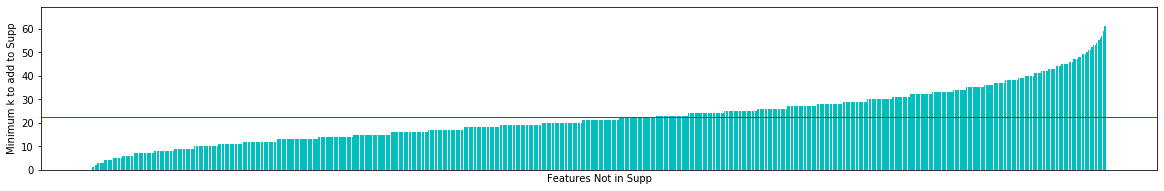

In [8]:
# Plot the results for all the features
plot_features_k_full(sorted_target_k_dict)

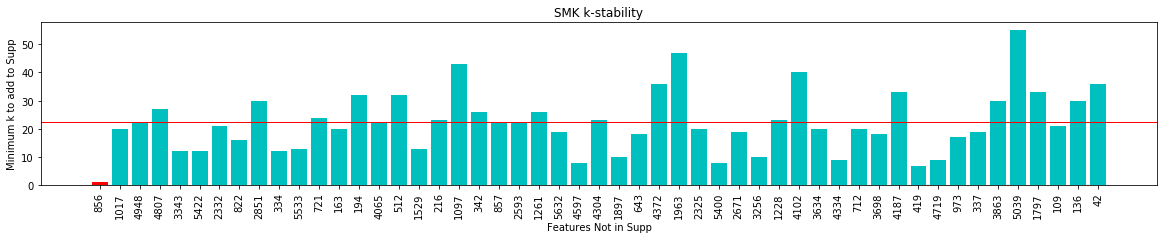

In [9]:
# Plot the results for random subset of size
size = 50
plot_features_k_random_subset(sorted_target_k_dict, size)

In [11]:
# Just for plotting the final images
import pickle
with open('TOX_dict.pkl', 'wb') as file:
    pickle.dump(sorted_target_k_dict, file)